In [1]:
%pylab inline
from lib.KDTreeEncoding import *

import xgboost as xgb
from lib.XGBHelper import *
from lib.XGBoost_params import *
from lib.score_analysis import *

from lib.logger import logger

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from numpy import load
from glob import glob
import pandas as pd
import pickle as pkl

Populating the interactive namespace from numpy and matplotlib


###  load image filenames

In [2]:
poverty_dir='/Users/yoavfreund/datasets/poverty_v1.1/'
#use the following line when running on datahub
poverty_dir = '/datasets/cs255-sp22-a00-public/poverty/'
depth=8   #for KDTree

In [3]:
## load file list
image_dir=poverty_dir+'/anon_images'
files=[]
files+=glob(f'{image_dir}/*.npz')
len(files)

19669

In [4]:
!ls ../public_tables/

country_test_reduct.csv  random_test_reduct.csv  train.csv


In [5]:
#load table entries
train_table='../public_tables/train.csv'
!ls -l $train_table

df=pd.read_csv(train_table,index_col=0)#[:1000]#！！！！！！！！！[:1000,:]
df.index=df['filename']
df.shape

-rw-r--r--. 1 t8zhou root 786422 Jun  2 13:46 ../public_tables/train.csv


(11365, 6)

In [6]:
#List the number of rows for each country, countries 0-4 are missing - the are in the country_test set
from collections import Counter
C=Counter(df['country'])
[(k,C[k]) for k in sorted(C)]

[(5, 676),
 (6, 641),
 (7, 329),
 (8, 586),
 (9, 1381),
 (10, 374),
 (11, 575),
 (12, 428),
 (13, 1068),
 (14, 581),
 (15, 756),
 (16, 248),
 (17, 246),
 (18, 581),
 (19, 424),
 (20, 456),
 (21, 543),
 (22, 1472)]

## train color encoder

Creates a KDtree in color space

In [7]:
%%time
## Generate encoding tree
train_size,tree=train_encoder(files,max_images=500,tree_depth=8)#!!500

used 500 images to train KDTree
KDTree training data shape= (25088000, 8)
CPU times: user 16.4 s, sys: 5.16 s, total: 21.6 s
Wall time: 21.9 s


In [8]:
%%time
## Encode all data using encoding tree
Enc_data=encoded_dataset(image_dir,df,tree,label_col='label')

CPU times: user 6min 40s, sys: 7.26 s, total: 6min 48s
Wall time: 6min 56s


In [9]:

D=DataSplitter(Enc_data.data)

### Train and test

In [10]:
# set parameters for XGBoost
param['max_depth']=3
param['num_round']=10
param

{'max_depth': 3,
 'eta': 0.3,
 'verbosity': 0,
 'objective': 'binary:logistic',
 'nthread': 7,
 'eval_metric': ['error', 'logloss'],
 'num_round': 10}

### Train on random split, urban and rural together

[{'i': 0, 'bst': <xgboost.core.Booster object at 0x7f286d8370f0>, 'y_pred': array([-0.9935731 , -0.6738586 ,  0.6590211 , ...,  0.2613902 ,
       -0.14104097, -0.28043044], dtype=float32), 'y_test': array([0, 0, 0, ..., 1, 0, 1], dtype=int8)}, {'i': 1, 'bst': <xgboost.core.Booster object at 0x7f286d82d4a8>, 'y_pred': array([-0.6417006 , -1.9614398 ,  1.0041237 , ..., -0.44263402,
       -0.446327  ,  0.25238672], dtype=float32), 'y_test': array([0, 0, 0, ..., 1, 0, 1], dtype=int8)}, {'i': 2, 'bst': <xgboost.core.Booster object at 0x7f286d81c668>, 'y_pred': array([-1.3661588 , -1.3661588 ,  0.75893885, ..., -0.23851779,
       -0.7306383 , -0.82400596], dtype=float32), 'y_test': array([0, 0, 0, ..., 1, 0, 1], dtype=int8)}, {'i': 3, 'bst': <xgboost.core.Booster object at 0x7f28cfd51898>, 'y_pred': array([-0.9487814, -0.8980095,  0.7468803, ...,  0.7473683,  0.4175923,
        0.6393694], dtype=float32), 'y_test': array([0, 0, 0, ..., 1, 0, 1], dtype=int8)}, {'i': 4, 'bst': <xgboost.core

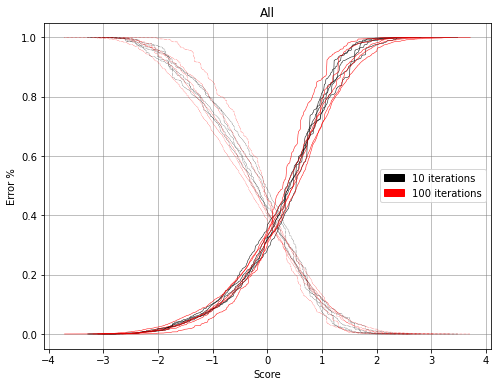

In [11]:
%%time
train_selector=np.random.rand(df.shape[0]) > 0.8
Train=D.get_subset(train_selector)
Test=D.get_subset(~train_selector)

param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=5)
# print(Train[0])
# print(Test)
param['num_round']=500
log100=simple_bootstrap(Train,Test,param,ensemble_size=5)
print(log10)

# param['num_round']=10
# log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
# param['num_round']=100
# log100=simple_bootstrap(Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log10,
        'style':['k:','k-'],
        'label':'10 iterations',
        'label_color':'k'
    },
    {   'log':log100,
        'style':['r:','r-'],
        'label':'100 iterations',
        'label_color':'r'
    }
]
_mean,_std=plot_scores(styled_logs,title='All')

pickle_file=f'data/DumpNoSplit.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))
!ls -l $pickle_file

In [12]:
x= pd.DataFrame(np.array([[12,32],[12,32],[12,32]]),columns=['xx','yy'])
x['xx'] = x['xx'].astype("category")
print(x['yy'])

0    32
1    32
2    32
Name: yy, dtype: int64


In [13]:

import xgboost as xgb
xgb.__version__

'1.3.3'

## Train on Urban only
Random split into train and test.

[{'i': 0, 'bst': <xgboost.core.Booster object at 0x7f28cd7a3cc0>, 'y_pred': array([-0.16361976,  1.0691668 ,  0.81626517, ..., -1.1423739 ,
       -1.4499197 , -0.00761023], dtype=float32), 'y_test': array([0, 1, 0, ..., 1, 1, 0], dtype=int8)}, {'i': 1, 'bst': <xgboost.core.Booster object at 0x7f28cd7b80b8>, 'y_pred': array([ 0.486744  , -0.21251166,  0.486744  , ..., -0.41074482,
       -2.021414  , -0.45204452], dtype=float32), 'y_test': array([0, 1, 0, ..., 1, 1, 0], dtype=int8)}, {'i': 2, 'bst': <xgboost.core.Booster object at 0x7f28cfccc2e8>, 'y_pred': array([ 0.7896556 ,  0.7896556 ,  0.7896556 , ..., -1.1808285 ,
       -2.28596   , -0.18758233], dtype=float32), 'y_test': array([0, 1, 0, ..., 1, 1, 0], dtype=int8)}, {'i': 3, 'bst': <xgboost.core.Booster object at 0x7f28cfcd3c50>, 'y_pred': array([ 0.8277676 ,  1.2799587 ,  0.75286835, ..., -0.731103  ,
       -1.5593169 ,  0.14755481], dtype=float32), 'y_test': array([0, 1, 0, ..., 1, 1, 0], dtype=int8)}, {'i': 4, 'bst': <xgboos

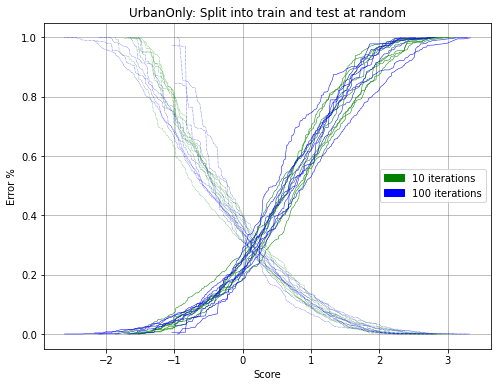

In [14]:
%%time
urban=True
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.7
# print(subData)
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

# param['num_round']=10
# log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
# param['num_round']=100
# log100=simple_bootstrap(Train,Test,param,ensemble_size=30)
param['gamma']=0.5
param['eta']=0.3
param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=8)
param['num_round']=500
log100=simple_bootstrap(Train,Test,param,ensemble_size=8)
print(log10)
styled_logs=[
    {   'log':log10,
        'style':['g:','g-'],
        'label':'10 iterations',
        'label_color':'g'
    },
    {   'log':log100,
        'style':['b:','b-'],
        'label':'100 iterations',
        'label_color':'b'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Dump{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))
!ls -l $pickle_file

## Train on Rural only
Random split into train and test.

accuracy_1 0.7058386017106731
accuracy_0 0.7058386017106731
accuracy_1 0.713276310896244
accuracy_0 0.713276310896244
accuracy_1 0.7036072889550019
accuracy_0 0.7036072889550019
accuracy_1 0.7095574563034586
accuracy_0 0.7095574563034586
accuracy_1 0.6675343994049833
accuracy_0 0.6675343994049833
accuracy_1 0.7073261435477873
accuracy_0 0.7073261435477873
accuracy_1 0.7062104871699516
accuracy_0 0.7062104871699516
accuracy_1 0.7255485310524359
accuracy_0 0.7255485310524359
accuracy_1 0.7024916325771662
accuracy_0 0.7024916325771662
accuracy_1 0.6946820379323169
accuracy_0 0.6946820379323169
accuracy_1 0.6868724432874674
accuracy_0 0.6868724432874674
accuracy_1 0.6716251394570473
accuracy_0 0.6716251394570473
accuracy_1 0.7021197471178877
accuracy_0 0.7021197471178877
accuracy_1 0.7214577910003719
accuracy_0 0.7214577910003719
accuracy_1 0.7251766455931573
accuracy_0 0.7251766455931573
accuracy_1 0.70918557084418
accuracy_0 0.70918557084418
-rw-r--r--. 1 t8zhou root 2048592 Jun  3 22:52

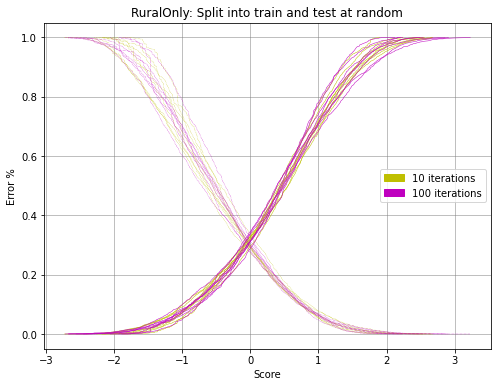

In [15]:
urban=False
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.8
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['gamma']=0.5
param['eta']=0.3
param['subsample']=0.9
param['max_depth']=5
# param['num_round']=10
# log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
# param['num_round']=100
# log100=simple_bootstrap(Train,Test,param,ensemble_size=30)
param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=8)
param['num_round']=500
log100=simple_bootstrap(Train,Test,param,ensemble_size=8)

styled_logs=[
    {   'log':log10,
        'style':['y:','y-'],
        'label':'10 iterations',
        'label_color':'y'
    },
    {   'log':log100,
        'style':['m:','m-'],
        'label':'100 iterations',
        'label_color':'m'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Dump{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))
!ls -l $pickle_file

In [16]:
log100[0]['bst'].best_ntree_limit

9